#Lane Identification with Canny Algorithm & Hough Transform

The Canny Algorithm & Hough Transform can be combined to make a simple traffic lane identification system.

Steps:
1. The edges in the image can be detected using the canny algorithm
2. Masking is applied to the image in order to recover only edges corresponding to road markings.
3. The hough transform is used to find lines that comprise the image.
4. The found lines are extrapolated and averaged into lane boundaries.


This notebook is based on the post https://www.kdnuggets.com/2017/07/road-lane-line-detection-using-computer-vision-models.html/2

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request
import math

In [5]:
# function to read images from Web addresses.
def url_to_image(url):
	user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
	headers ={'User-Agent':user_agent,}
	request=urllib.request.Request(url,None,headers)
	resp = urllib.request.urlopen(request)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image

#Load Image
Image is imported from URL location and gaussian blur applied, the image is conveted to grey scale.

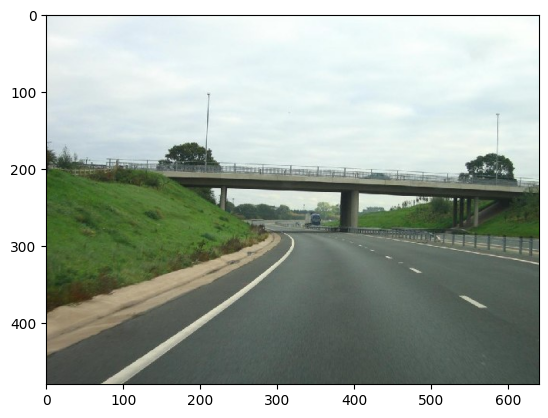

In [6]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/e/e7/New_A500_Dual_Carriageway_-_geograph.org.uk_-_65214.jpg"
image = url_to_image(image_url)
plt.imshow(image)
# Blur input image
cv2.GaussianBlur(image, (5, 5), 0)
# Convert to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny Algorithm
The open CV implementation of the canny algorithm is applied to find edges in the image.

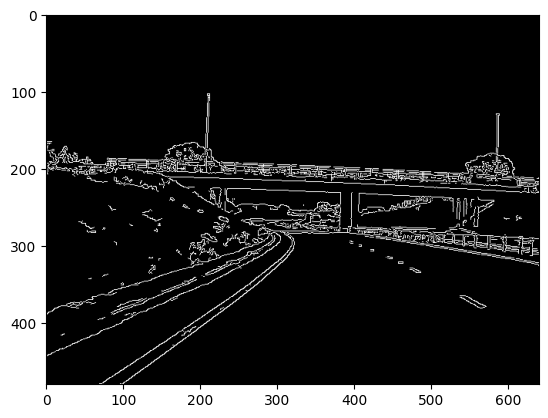

In [7]:
#Apply Canny Algorithm
min_thres = 80
max_thres = 150
edges = cv2.Canny(gray,min_thres,max_thres,apertureSize = 3)
plt.imshow(edges,'gray')

# Create Mask for Region of Interest.

A Mask for the Region of Interest containing edges corresponding to lane markings recovered from the image can be created using the cv2.fillPoly command that can create a a filled region, the number of sides of the region is determined by the number of vertices applied. These are manually determined in this simple example.

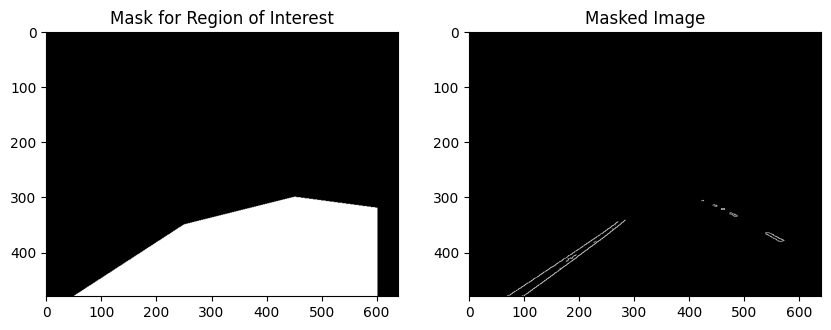

In [8]:
# points arranged clockwise
l1 = [50,480]
l2 = [250,350]
r1 = [450,300]
r2 = [600,320]
r3 = [600,480]

pts = np.array([[l1,l2,r1,r2,r3 ]], dtype=np.int32)

#Mask region of Interest.
def mask_img(image,vertices):
    #Create mask
    mask = np.zeros_like(edges)
    #Add white to region of interest
    cv2.fillPoly(mask, vertices, 255)
    # apply mask to image
    masked_image = cv2.bitwise_and(image,image, mask=mask)
    return mask,masked_image

mask,masked_image = mask_img(edges,pts)

f, axarr = plt.subplots(1,2,figsize=(10,6))
axarr[0].imshow(mask,'gray')
axarr[0].title.set_text('Mask for Region of Interest')
axarr[1].imshow((masked_image),'gray')
axarr[1].title.set_text('Masked Image')

#Hough Transform

The Hough Transform is used to recover lines corresponding to the edges in the image. The probablistic hough transform is used https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

(7, 1, 4)


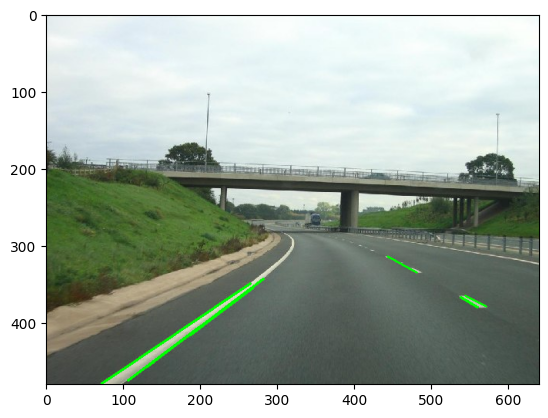

In [9]:
# Reload image
image = url_to_image(image_url)
# Apply Hough Transform to find lines
n_max = 40
#hough lines
rho_res = 1
theta_res = np.pi/180
threshold = 30
min_line_len = 20
max_line_gap = 20

lines = cv2.HoughLinesP(masked_image,rho_res,theta_res,threshold, np.array([]),
              minLineLength=min_line_len, maxLineGap=max_line_gap)

print(np.shape(lines))


#lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
for line in lines:
   x1,y1,x2,y2 = line[0]
   cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
#for x1,y1,x2,y2 in lines[0:n_max]:
#    cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)

plt.imshow(image)

The lines produced by the Hough Transform correspond to the edges in the image. In order to determine the boundary of the lane, the lines are extrapolated and averaged using the function below.

In [10]:
image = url_to_image(image_url)
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.
    """
    imshape = img.shape

    # these variables represent the y-axis coordinates to which
    # the line will be extrapolated to
    ymin_global = img.shape[0]
    ymax_global = img.shape[0]

    # left lane line variables
    all_left_grad = []
    all_left_y = []
    all_left_x = []

    # right lane line variables
    all_right_grad = []
    all_right_y = []
    all_right_x = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            gradient, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            ymin_global = min(min(y1, y2), ymin_global)

            if (gradient > 0):
                all_left_grad += [gradient]
                all_left_y += [y1, y2]
                all_left_x += [x1, x2]
            else:
                all_right_grad += [gradient]
                all_right_y += [y1, y2]
                all_right_x += [x1, x2]

    left_mean_grad = np.mean(all_left_grad)
    left_y_mean = np.mean(all_left_y)
    left_x_mean = np.mean(all_left_x)
    left_intercept = left_y_mean - (left_mean_grad * left_x_mean)

    right_mean_grad = np.mean(all_right_grad)
    right_y_mean = np.mean(all_right_y)
    right_x_mean = np.mean(all_right_x)
    right_intercept = right_y_mean - (right_mean_grad * right_x_mean)

    # Make sure we have some points in each lane line category
    if ((len(all_left_grad) > 0) and (len(all_right_grad) > 0)):
        upper_left_x = int((ymin_global - left_intercept) / left_mean_grad)
        lower_left_x = int((ymax_global - left_intercept) / left_mean_grad)
        upper_right_x = int((ymin_global - right_intercept) / right_mean_grad)
        lower_right_x = int((ymax_global - right_intercept) / right_mean_grad)

        cv2.line(img, (upper_left_x, ymin_global),
                      (lower_left_x, ymax_global), color, thickness)
        cv2.line(img, (upper_right_x, ymin_global),
                      (lower_right_x, ymax_global), color, thickness)
        # Add lane between the lines
        lane = np.zeros_like(img)
        vertices = np.array([[[lower_left_x, ymax_global],[upper_left_x, ymin_global],[upper_right_x, ymin_global],[lower_right_x, ymax_global]]], dtype=np.int32)
        cv2.fillPoly(lane, vertices, (255,255,153))
        final_img = cv2.addWeighted(img, 0.8, lane, 0.3, 0)

    return final_img

Text(0.5, 1.0, 'Lane Boundary and Lane Region found from Hough Tranform Lines')

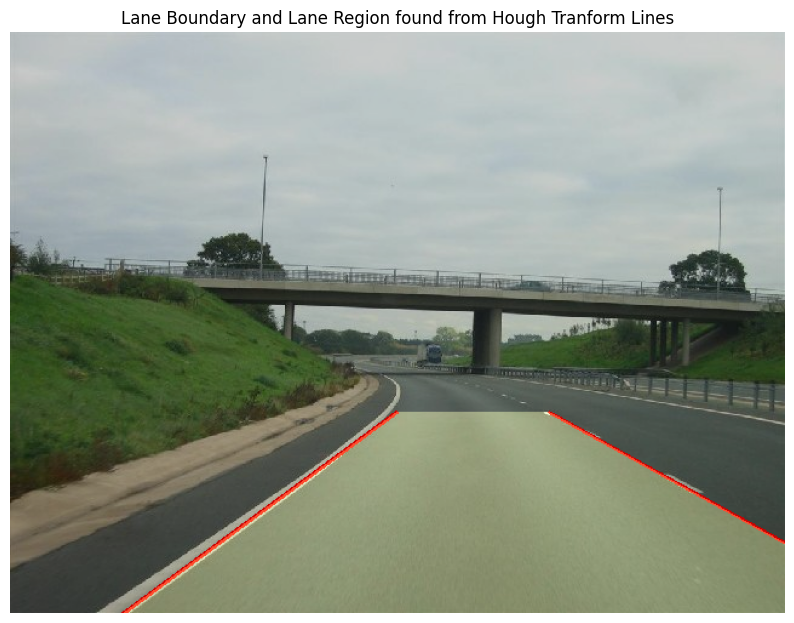

In [11]:
final_img = draw_lines(image,lines)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(final_img)
plt.title('Lane Boundary and Lane Region found from Hough Tranform Lines')